# **Molecular Dynamics**

In [1]:
# Python libraries and functions used in this project

import math
import random as rdm
import numpy as np
from numpy import random
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython.display import HTML

## 1 - The model

### 1.1 - Interaction potential

Here we will consider a set of $N$ *classical* particles of mass $m$ that interact pair-wise via the Lennard-Jones potential and moving according Newton's laws in two dimensions. The Lennard-Jones potential is given by 

$$
V(r_{ij}) = 4\epsilon\left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right],
$$

where $r_{ij} = r_{ji}$ is the Euclidean distance between the particles $i$ and $j$, $\epsilon$ is the strength of the potential and $\sigma$ is a length scale. 

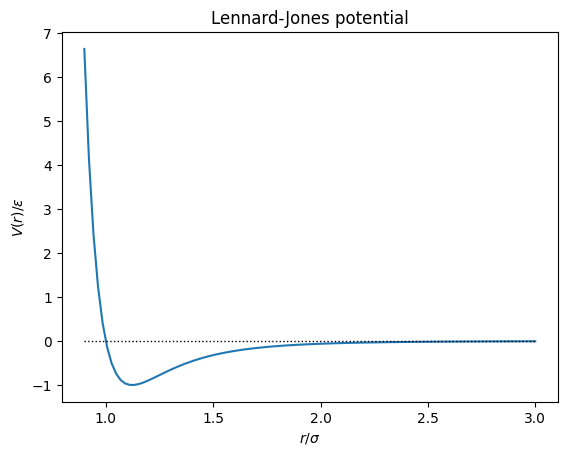

In [2]:
def v(x): 
    """Function that returns the Lennard-Jones potential"""
    return 4./(x**12) - 4./(x**6)

x = np.linspace(0.9, 3, 100)

plt.plot(x, v(x))
plt.plot(x, 0*x, color = 'black', linestyle = 'dotted', linewidth = 1)
plt.title("Lennard-Jones potential")
plt.xlabel('$r/\\sigma$')
plt.ylabel('$V(r)/\\epsilon$')

plt.show()

We see from the shape of the Lennard-Jones potential above that for long distances, i.e. for $r \gtrsim \sigma$, the potential is attractive, while for $r \lesssim \sigma$ the potential is strongly repulsive. The potential also has a minimum at $r_0 = 2^\frac{1}{6}\sigma$, where $V(r_0) = -\epsilon$.

This potential is a good model for innert gases, like ideal gases, that cannot for chemical bonds, i.e. cannot exchange electrons. The $\left(\frac{\sigma}{r}\right)^6$ tail models dipole interactions that are produce by the interaction of the molecules electronic clouds via the electorstatic force, that distorts the clouds, attractive producing electric dipole forces. The $\left(\frac{\sigma}{r}\right)^{12}$-term models the strong repulsion that appears out of the superpposition of the molecules electronic clouds, and it is produced by Pauli's exclusion principle. This principle express the empirical fact that two electrons cannot occupy the same state.  

### 1.2 Boundary conditions

For simplicit, we will consider periodic boundary conditions. This means that in a lattice of size $L$, if the particle moves to a position $x = L + a$, the particle is the moved to the position $x' = x - L = a$, assuming here $a < L$. Hence, if the particles leaves the lattice on the right, it reappers on the left. And vice-versa. If the particle moves to the position $x = a < 0$, then it is moved to the position $x' = a + L < L$.

This choice of boundary conditions have some advantages. In a real gas we typically have $N \sim 10^{23}$ particles, which would be very costly to simmulate in a computer. For small set of particles, say $N \sim 100$, assuming the the boundary of the lattice are hard walls as in a vessel might produce undesirable boundary effects that one would not find in real-life situations. The periodic boundary condition then allows us to simulate the situation in which we are observing a sample of the bulk of the gas, away from the vessel walls at a constant density 

## 2 - Method

### 2.1 - Numerical method

To numerically compute the position of the gas molecules, we will use the so-called **Verlet method**, see e.g. *Computational Physics* by N. Giordano. This method is suitable when the interaction potential does not depend on the velocity. Moreover it is a method easy to implement and has good numerical precision.

Let us consider a function $y(t)$ satisfy the equation of motion $\frac{d^2y(t)}{dt^2} = f[y(t)]$ and its Taylor expansion going forward and backward in time around the instant $t_i$ with a time step $\Delta t$,

$$
y(t_i + \Delta t) = y(t_i) + \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} + \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4)
$$
and
$$
y(t_i - \Delta t) = y(t_i) - \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} - \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4).
$$

Denoting $y_i \equiv y(t_i)$, $y_{i-1} \equiv y(t_i - \Delta t)$, $y_{i+1} \equiv y(t_i + \Delta t)$ and $f(y) = $, we have that

$$
y_{i + 1} = 2 y_i - y_{i - 1} + \Delta t^2f(y_i) + O(\Delta t^4),
$$

hence the error is of order $O(\Delta t^4)$. The Verlet method is thus approximates $\frac{d^2y}{dt^2}$ symmetrically using differences centered at the instant $t_i$ with high accurace. We can also obtain the velocity $v_i = \frac{dy_i}{dt}$ from the Verlet method by taking

$$
y_{i+1} - y_{i-1} = 2\Delta t v_i + O(\Delta t^3)\;\;\;\; \rightarrow \;\;\;\; v_i = \frac{y_{i+1} - y_{i-1}}{2\Delta t} + O(\Delta t^3).
$$

### 2.2 Computation of the force

The expression for the interaction force between two particles is

$$
\vec{F}(\vec{x} - \vec{x}') = \frac{24 \epsilon}{\sigma}\left[2\left(\frac{\sigma}{r}\right)^{13} - \left(\frac{\sigma}{r}\right)^7\right]
\frac{\vec{x} - \vec{x}'}{\vec{x} - \vec{x}'} 
$$

with $r = \| \vec{x} - \vec{x}'\|$. 

To simplify the numerical computation we will only consider the interaction between particles that are apart by up to a distance of $3\sigma$. This introduces an error in the computation of force of the order $1/3^7 \sim 10^{-4}$. Hence, if we choose $\Delta t \sim 10^{-3}$, the error in the equation for the position is still consistent with the error in the equation for the velocity.

We also need to take into account the periodic boundary condition when computing the force so the reappearnce of a particle on the other side of the lattice is consistent with the dynamics. This is accomplished by computing the shortest distance between two particles and using it to compute the force between them. Hence, suppose two particles $i$ and $j$ at positions $x_i$ and $x_j$. If their coordinate distance is less than $L/2$, then we simply use $x_i - x_j$, otherwise we have to use the complement of the coordinate distance given by $x_i - x_j - \textrm{sgn}(x_i - x_j)L/2$. 

## 3 - Initial conditions

In [3]:
def impose_boundary_condition(x_coord_n, y_coord_n, x_coord_n1, y_coord_n1):
    """
    Updates the xy coordinates of the particles by imposing 
    periodic boundary conditions. 
    
    Returns the updated x and y coordinates arrays.
    
    Keyword arguments:
    
    x_coord_n -- x coordinate at time step n, array
    y_coord_n -- y coordinate at time step n, array
    x_coord_n1 -- x coordinate at time step n+1, array
    y_coord_n1 -- y coordinate at time step n+1, array
    """
    
    for i, (ixn, iyn, ixn1, iyn1) in enumerate(zip(x_coord_n, y_coord_n, x_coord_n1, y_coord_n1)):
        
        if ixn1 <= 0:
            ixn1 = ixn1 + L
            ixn = ixn + L
            
            x_coord_n1[i] = ixn1
            x_coord_n[i] = ixn
            
        if ixn1 >= L:
            ixn1 = ixn1 - L
            ixn = ixn - L
    
            x_coord_n1[i] = ixn1
            x_coord_n[i] = ixn
        
        if iyn1 <= 0:
            iyn1 = iyn1 + L
            iyn = iyn + L
            
            y_coord_n1[i] = iyn1
            y_coord_n[i] = iyn
            
        if iyn1 >= L:
            iyn1 = iyn1 - L
            iyn = iyn - L
        
            y_coord_n1[i] = iyn1
            y_coord_n[i] = iyn
            
    return x_coord_n, y_coord_n, x_coord_n1, y_coord_n1
    



def generate_initial_conditions(grid_side = 20, gas_density = 0.25, initial_vel = 1):
    """
    Generates a random initial condition for the position and velocity 
    of the particles.
    
    Returns the initial xy particles position and their xy velocity component.
    
    Keyword arguments:
    
    grid_side   -- side of lattice, float (default 20.) 
    Nparticles  -- particle number, integer (default 100)
    initial_vel -- modulus of the initial velocity, float (default 1.)
    """

    a = 1/(math.sqrt(gas_density)) # Size of the lattice cell
    
    x_0, y_0 = np.mgrid[a/2:grid_side + a/2:a, a/2:grid_side + a/2:a]
    
    Nparticles = len(x_0.flatten())
    
    x_0 = x_0.flatten() + a/2*(random.rand(Nparticles,) - 1/2)
    y_0 = y_0.flatten() + a/2*(random.rand(Nparticles,) - 1/2)
    
    
    x_m1, y_m1, x_0, y_0 = impose_boundary_condition(np.zeros(Nparticles,),np.zeros(Nparticles,), x_0, y_0)
    
    del x_m1, y_m1
    
    rand_theta = 2*math.pi*random.rand(Nparticles,)
    vx_0 = initial_vel*np.sin(rand_theta)
    vy_0 = initial_vel*np.cos(rand_theta)
    
    # We compute the position of the particles at the next time step
    x_1 = x_0 + vx_0*dt
    y_1 = y_0 + vy_0*dt

    # We impose the periodic boundary conditions in both the x and y directions
    x_0, y_0, x_1, y_1 = impose_boundary_condition(x_0, y_0, x_1, y_1)
            
    return Nparticles, x_0, y_0, vx_0, vy_0, x_1, y_1

Number of particles in the system: 100


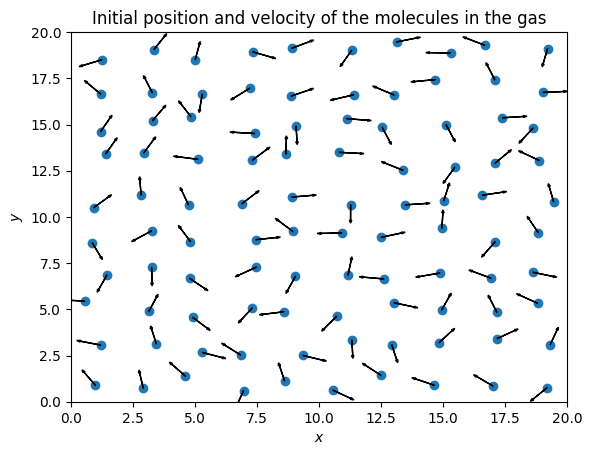

In [4]:
L = 20 # Side of bi-dimensional volume
rho = 0.25 #Number of particles
v_0 = 5 # Modulus of the initial velocity
dt = 0.001 #Time step
N_time_steps = 5000 #Number of time steps

N, x_0, y_0, vx_0, vy_0, x_1, y_1 = generate_initial_conditions(L, rho, v_0)

plt.axis([0, L, 0, L])

print('Number of particles in the system:', N)

plt.scatter(x_0,y_0)
for i in range(0, N):
        plt.arrow(x_0[i],y_0[i],vx_0[i]/5,vy_0[i]/5,length_includes_head=True,head_width=0.1,color='black') #We halve the velocity so it looks nicer in the picture

plt.title('Initial position and velocity of the molecules in the gas')
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.show()

## 4 - Dynamics

In [9]:
def copy_sgn_funct(x, y):
    """
    Returns the absolute value of x times the 
    sign of y.
    
    Keyword arguments:
    
    x  -- float or int 
    y  -- float or int
    """
    if y > 0:
        return abs(x)
    else:
        return -abs(x)


def shortest_distance_squared(x_coord_distance, y_coord_distance):
    """
    Computes the shortest Euclidean distance between
    two particles using periodic boundary conditions.

    Returns the square of the Euclidean distance.
    
    Keyword arguments:
    
    x_coord_distance  -- float, coordinate distance in the x direction 
    y_coord_distance  -- float, coordinate distance in the y direction
    """
    
    if (abs(x_coord_distance) > L/2):
        x_coord_distance = x_coord_distance - copy_sgn_funct(L, x_coord_distance)
    
    if (abs(y_coord_distance) > L/2):
        y_coord_distance = y_coord_distance - copy_sgn_funct(L, y_coord_distance)
        
    distance_squared = x_coord_distance*x_coord_distance + y_coord_distance*y_coord_distance
    
    return distance_squared



def compute_force(x_coord, y_coord):
    """
    Computes the forces between any pair particles using the Lennard-Jonnes potential
    and the shortest distance as defined by periodic boundary conditions in 
    the function 'shorted_distance'.
    
    Returns the x and y components of the force between the particles.
    
    Keyword arguments:
    
    x_coord  -- x coordinate 
    y_coord  -- y coordinate
    """
    
    N = len(x_coord)
    
    force_x = np.zeros(N,)
    force_y = np.zeros(N,)

    for i in range(0, N):
        for j in range(i + 1, N):
            dx = x_coord[i] - x_coord[j]
            dy = y_coord[i] - y_coord[j]
                
            r_squared = shortest_distance_squared(dx,dy)
                
            if (r_squared < 9.):
                if (r_squared < 1e-3): #avoids 0 denominator
                    r_squared = 1e-3

                r_squared_inverse = 1./r_squared
                f = 0
                f = 24*(2*r_squared_inverse**7 - r_squared_inverse**4)
            else:
                f = 0
                                  
            force_x[i] = f*dx + force_x[i]
            force_x[j] = -f*dx + force_x[j]
                
            force_y[i] = f*dy + force_y[i] 
            force_y[j] = -f*dy + force_y[j]
            
    return force_x, force_y


def time_evolution():
    """Document this function"""
    
    x_n2 = np.round(2*x_n1 - x_n + force_x_n1*dt*dt, 11)
    y_n2 = np.round(2*y_n1 - y_n + force_y_n1*dt*dt, 11)
    
    vx_n = np.round((x_n2 - x_n)/(2*dt), 8)
    vy_n = np.round((y_n2 - y_n)/(2*dt), 8)
    
    return x_n2, y_n2, vx_n, vy_n


In [10]:
def init_state():
    particles.set_offsets([x_n, y_n])
    return particles

def dynamics(step_i):

    global x_n, y_n, vx_n, vy_n, x_n1, y_n1, force_x_n1, force_y_n1
    
    particles.set_data(x_n1, y_n1)
    
    force_x_n1, force_y_n1 = compute_force(x_n1, y_n1)
    x_n2, y_n2, vx_n, vy_n = time_evolution() 

    total_kinetic_energy = 0.
    
    for i in range(0, N):
        total_kinetic_energy += 0.50*(vx_n[i]*vx_n[i] + vy_n[i]*vy_n[i]) 
    
    x_n = x_n1
    x_n1 = x_n2
    
    y_n = y_n1
    y_n1 = y_n2
    
    x_n, y_n, x_n1, y_n1 = impose_boundary_condition(x_n, y_n, x_n1, y_n1)
    
    return particles, total_kinetic_energy

In [11]:
N, x_n, y_n, vx_n, vy_n, x_n1, y_n1 = generate_initial_conditions(L, rho, v_0)

fig = plt.figure()
ax = plt.axes(xlim = (0, L), ylim = (0, L))
particles, = ax.plot([], [], 'bo')

metadata = dict(title = 'Molecular Dynamics', artist = 'WCC Lima')
writer = FFMpegWriter(fps = 80, metadata = metadata)

particles.set_data(x_n, y_n)
#for i in range(0, N):
#    vel_vecs = plt.arrow(x_n[i],y_n[i],vx_n[i],vy_n[i],length_includes_head=True,head_width=0.1,color='black')

TKE = np.array([])    

with writer.saving(fig, 'molecular_dynamics.mp4', 200):
    for time_step in range (0, N_time_steps):
        #vel_vecs.remove()
        particles, e = dynamics(time_step)
        TKE = np.append(TKE, np.array([e]))
        #for i in range(0, N):
        #    vel_vecs = plt.arrow(x_n[i],y_n[i],vx_n[i],vy_n[i],length_includes_head=True,head_width=0.1,color='black')
        writer.grab_frame()

plt.close()

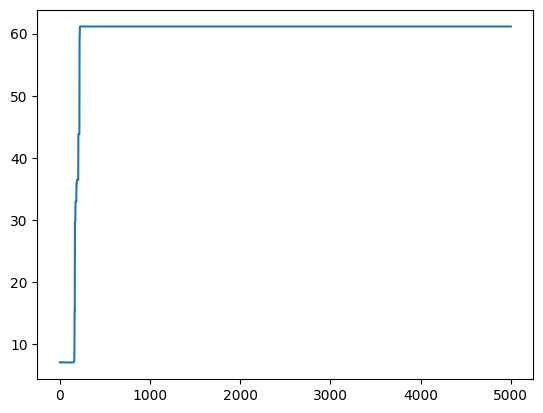

In [12]:
plt.plot(np.linspace(0,N_time_steps, N_time_steps), np.log(TKE))
#plt.xlim([0,2000])
plt.show()

In [ ]:
%matplotlib ipympl

In [ ]:

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

plt.show()

In [ ]:
%matplotlib inline

plt.rcParams["animation.html"] = "jshtml"

fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)

ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.close()
ani